# Sampling with $\sigma$

##### Keywords: bayesian,  normal-normal model, MAP,  MCMC

In [7]:
%matplotlib inline
import numpy as np
import scipy as  sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")

## The Normal Model

 
 A random variable $Y$ is normally distributed with mean $\mu$ and variance $\sigma^2$. Thus its density is given by :
 
 $$ p(y \vert \mu, \sigma^2) =  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{y-\mu}{2 \sigma})^2} $$
 
 
Suppose our model is $\{y_1, \ldots, y_n \vert \mu, \sigma^2 \} \sim N(\mu, \sigma^2)$ then
the likelihood is 

$$
p(y_1, \ldots, y_n \vert \mu, \sigma^2) = 
\prod_{i=1}^{n} p(y_i \vert \mu, \sigma^2)=\prod_{i=1}^{n}  \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{-( \frac{(y_i-\mu)^2}{2\sigma^2})} = 
\frac{1}{ \sqrt{ 2 \pi \sigma^2}}   \exp \left\{  - \frac{1}{2}  \sum_i \frac{(y_i-\mu)^2}{\sigma^2} \right\} 
$$

We can now write the posterior for this model thus:

$$ p( \mu, \sigma^2 \vert  y_1, \ldots, y_n, \sigma^2)  \propto \frac{1}{ \sqrt{ 2 \pi \sigma^2}} e^{ - \frac{1}{2\sigma^2} \sum (y_i - \mu)^2 } \, p(\mu, \sigma^2)$$

Say we have the prior

$$ p(\mu \vert \sigma^2) = \exp \left\{ -\frac{1}{2 \tau^2} (\hat{\mu}-\mu)^2 \right\} $$

Now, keeping in mind that $p(\mu, \sigma^2) = p(\mu \vert \sigma^2) p(\sigma^2)$, we will need tp specify the prior on the variance. Our sample estimate is 1, so we can be fairly informative if we consider a half-normal with a standard deviation of 10.

## Example of the normal model for $\sigma$ to be sampled.

We have data on the wing length in millimeters of a nine members of a particular species of moth. We wish to make inferences from those measurements on the population mean $\mu$. Other studies show the wing length to be around 19 mm. We also know that the length must be positive. We can choose a prior on $\mu$ that is normal and most of the density is above zero ($\mu=19.5,\tau=10$). This is only a **marginally informative** prior.

Many bayesians would prefer you choose relatively uninformative priors.

The measurements were: 16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8 giving $\bar{y}=18.14$. 

In [8]:
Y = [16.4, 17.0, 17.2, 17.4, 18.2, 18.2, 18.2, 19.9, 20.8]
#Data Quantities
sig_data = np.std(Y) # sample estimatge of $\sigma$
mu_data = np.mean(Y)
n = len(Y)
print("sigma", sig_data, "mu", mu_data, "n", n)

sigma 1.33092374864 mu 18.1444444444 n 9


In [9]:
# normal prior for mean parameter
# Prior mean
mu_prior = 19.5
# prior std
std_prior = 10 

## Sampling by code

We now set up code to do metropolis using logs of distributions:

In [182]:
def metropolis(logp, qdraw, stepsize, nsamp, xinit):
    samples=np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, stepsize)
        logp_star = logp(x_star)
        logp_prev = logp(x_prev)
        logpdfratio = logp_star -logp_prev
        u = np.random.uniform()
        if np.log(u) <= logpdfratio:
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted

# this code is taken and adapted from https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section4_2-MCMC.ipynb

rnorm = np.random.normal
runif = np.random.rand

def metropolis(logp, n_iterations, initial_values, prop_std=[1,1]):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = logp(*trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000: 
            print('Iterations left: ', n_iterations-i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = logp(*p)
    
            # Log-acceptance rate
            logalpha = proposed_prob - current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < logalpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted


In [183]:
4000 % 1000

0

Remember, that up to normalization, the posterior is the likelihood times the prior. Thus the log of the posterior is the sum of the logs of the likelihood and the prior.

In [185]:
from scipy.stats import norm, halfcauchy
logprior = lambda mu, sigma: norm.logpdf(mu, loc=mu_prior, scale=std_prior) + norm.logpdf(sigma, loc=sig_data, scale=2)
loglike = lambda mu, sigma: np.sum(norm.logpdf(Y, loc=mu, scale=sigma))
logpost = lambda mu, sigma: loglike(mu, sigma) + logprior(mu, sigma)

Now we sample:

In [200]:
x0=[mu_data, sig_data]
p_std = [1.0, 1.0]
nsamps=30000
samps, acc = metropolis(logpost, nsamps, x0, prop_std=p_std)

Iterations left:  30000
Iterations left:  20000
Iterations left:  10000


The acceptance rate is reasonable. You should shoot for somewhere between 20 and 50%.

In [201]:
np.array(acc)/nsamps


array([ 0.50543333,  0.3768    ])

In [202]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

In [215]:
samps[20000::,:].shape

(10001, 2)

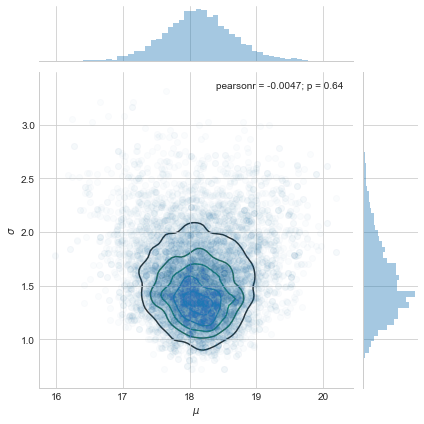

In [232]:
sns.jointplot(pd.Series(samps[20000::,0], name="$\mu$"), pd.Series(samps[20000::,1], name="$\sigma$"), alpha=0.02).plot_joint(sns.kdeplot, zorder=0, n_levels=6, alpha=1)

In [203]:
musamps = samps[:,0]
sigsamps = samps[:,1]

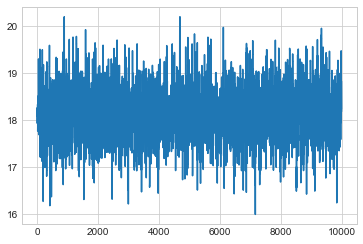

In [204]:
plt.plot(musamps[20000::])

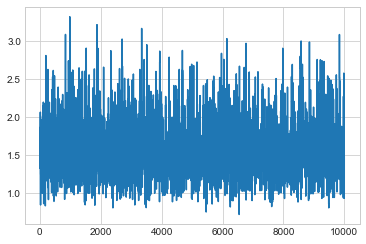

In [205]:
plt.plot(sigsamps[20000::])

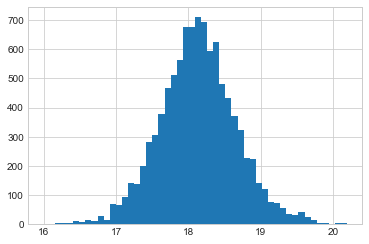

In [206]:
plt.hist(musamps[20000::], bins=50);

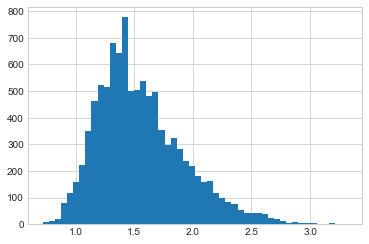

In [207]:
plt.hist(sigsamps[20000::], bins=50);

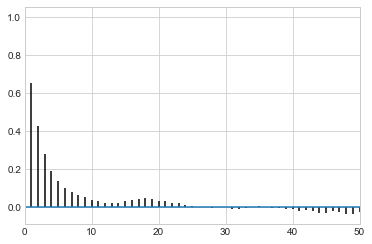

In [208]:
corrplot(musamps[20000::])

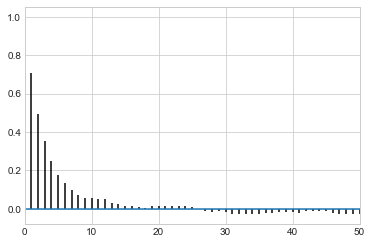

In [209]:
corrplot(sigsamps[20000::])

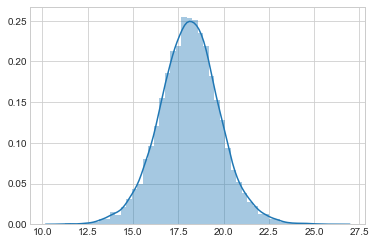

In [222]:
post_pred_func = lambda postmu, postsig: norm.rvs(loc = postmu, scale = postsig)
post_pred_samples = post_pred_func(samps[20000::,0], samps[20000::,1])
sns.distplot(post_pred_samples)